In [1]:
from Data import *

import pandas as pd
import string
import random

import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np
import tqdm
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_name = 'Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt'
loss_file = "Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout)_loss.npz"
print('Using {} device'.format(device))

Using cuda device


In [2]:
sp = 0
tp = 1
pg = 2
p = 3

def split_data(data):
    split_data = []
    for string in data:
        split_space = string.split()
        for i, word in enumerate(split_space):
            split_data.append(word)
    return split_data

def y_train_make(n):
    np_sp = np.array([sp])
    np_tp = np.array([tp])
    np_pg = np.array([pg])
    np_p = np.array([p])
    y = []
    for i in range(n):
        y.append(np_sp)
        y.append(np_tp)
        y.append(np_pg)
        y.append(np_p)
    return np.array(y)

def src_trg_split(data):
    src = []
    trg = []
    for i in range(0, len(data), 2):
        src.append(data[i])
        trg.append(data[i+1])
    return np.array(src), np.array(trg)

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_data = np.squeeze(pd.read_csv('train.txt', header=None))

y_train = y_train_make(len(train_data))

def to_one_hot(label):
    one_hot =  np.zeros((len(label), 4))
    one_hot[np.arange(len(label)), label[:, 0]] = 1
    return one_hot
    
y_train = to_one_hot(y_train)
train_data = split_data(train_data)
train_loader = DataTransformer(train_data, y_train, use_cuda=True)

In [4]:
test_data = np.squeeze(pd.read_csv('test.txt', header=None))
test_data = split_data(test_data)
test_data = np.array(test_data)
src, trg = src_trg_split(test_data)
test_src = []
test_trg = []

for word in src:
    test_src.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))

for word in trg:
    test_trg.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))
"""
sp -> p
sp -> pg
sp -> tp
sp -> tp
p  -> tp
sp -> pg
p  -> sp
pg -> sp
pg -> p
pg -> tp
"""
test_c_src = np.array([sp, sp, sp, sp, p, sp, p, pg, pg, pg]).reshape(-1, 1)
test_c_trg = np.array([p, pg, tp, tp, tp, pg, sp, sp, p, tp]).reshape(-1, 1)
test_c_src = Variable(torch.LongTensor(to_one_hot(test_c_src))).to(device)
test_c_trg = Variable(torch.LongTensor(to_one_hot(test_c_trg))).to(device)

In [5]:
def test_eval(model, epoch):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():    
        src_c = test_src
        trg_c = test_trg
        optimizer.zero_grad()            
        output = model(src, trg, src_c, trg_c, 0) #turn off teacher forcing
        loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
        
        if epoch % 10 == 0:
            print("=========show testing result=========")
            for i in range(output.shape[-1]):
                show_result(trg, output, i)
                print()
            
        return loss
    
def show_result(target, output, index):
    print("Ground true: ", end="")
    for i in range(max_len):
        tmp = trg[index, i]
        if tmp == 1:
            break
        elif tmp == 0:
            continue
        print(chr(trg[index, i]-7+ord('a')), end="")
    
    print(" Predict: ", end="")
    for i in range(max_len):
        print(chr(np.argmax(o[index, i, 3:])-4+ord('a')), end="")

In [6]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size, lat_dim):
        """Define layers for a vanilla rnn encoder"""
        super(Encoder, self).__init__()
        self.embedding_size = embedding_size

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc = nn.Linear(self.embedding_size+4, self.embedding_size)
        self.lstm = nn.LSTM(embedding_size, output_size)
        
        self.hidden2mean = nn.Linear(output_size, lat_dim)
        self.hidden2logv = nn.Linear(output_size, lat_dim)
        
        self.cell2mean = nn.Linear(output_size, lat_dim)
        self.cell2logv = nn.Linear(output_size, lat_dim)

    def forward(self, input_seqs, input_lengths, label, hidden=None, cell=None):
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        label = label.view(1, label.shape[0], label.shape[1])
        hidden = torch.cat([hidden, label], dim=2)
        hidden = self.fc(hidden)
        cell = hidden
        packed_outputs, (hidden, cell) = self.lstm(packed, (hidden, cell))
        outputs, output_lengths = pad_packed_sequence(packed_outputs)
        
        hidden_means = self.hidden2mean(hidden)
        hidden_logv = self.hidden2logv(hidden)
        
        cell_means = self.cell2mean(cell)
        cell_logv = self.cell2logv(cell)
        
        return outputs, hidden_means, hidden_logv, cell_means, cell_logv
    
    def initHidden(self, batch_size):
        return torch.zeros([1, batch_size, self.embedding_size]) # (D * num_layers, batch_size, H_out) 

In [7]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, lat_dim, max_length, teacher_forcing_ratio, sos_id, use_cuda):
        """Define layers for a vanilla rnn decoder"""
        super(Decoder, self).__init__()

        self.word_dropout_rate = 0
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.latent2hidden = nn.Linear(lat_dim+4, hidden_size)
        self.latent2cell = nn.Linear(lat_dim+4, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)  # work with NLLLoss = CrossEntropyLoss

        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_id = sos_id
        self.use_cuda = use_cuda

    def forward_step(self, inputs, hidden, cell):
        # inputs: (time_steps=1, batch_size)
        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded.view(1, batch_size, self.hidden_size)  # S = T(1) x B x N
        rnn_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # S = T(1) x B x H
        rnn_output = rnn_output.squeeze(0)  # squeeze the time dimension
        output = self.log_softmax(self.out(rnn_output))  # S = B x O
        return output, hidden, cell

    def forward(self, context_vector, decoder_cell, targets):

        # Prepare variable for decoder on time_step_0
        target_vars, target_lengths = targets
        batch_size = context_vector.size(1)
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))

        # Pass the context vector
        decoder_hidden = context_vector

        max_target_length = max(target_lengths)
        decoder_outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()
            
        if self.word_dropout_rate:
            prob = torch.rand(decoder_input.size()).to(device)
            prob[(decoder_input.data - train_loader.vocab.char2idx["SOS"]) * (decoder_input.data - train_loader.vocab.char2idx['PAD']) == 0] = 1
            decoder_input[prob < self.word_dropout_rate] = train_loader.vocab.char2idx['UNK']

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        # Unfold the decoder RNN on the time dimension
        for t in range(max_target_length):
            decoder_outputs_on_t, decoder_hidden, decoder_cell = self.forward_step(decoder_input, decoder_hidden, decoder_cell)
            decoder_outputs[t] = decoder_outputs_on_t
            if use_teacher_forcing:
                decoder_input = target_vars[t].unsqueeze(0)
            else:
                decoder_input = self._decode_to_index(decoder_outputs_on_t)

        return decoder_outputs, decoder_hidden, decoder_cell

    def evaluate(self, context_vector, decoder_cell):
        batch_size = context_vector.size(1) # get the batch size
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))
        decoder_hidden = context_vector

        decoder_outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        # Unfold the decoder RNN on the time dimension
        for t in range(self.max_length):
            decoder_outputs_on_t, decoder_hidden, decoder_cell = self.forward_step(decoder_input, decoder_hidden, decoder_cell)
            decoder_outputs[t] = decoder_outputs_on_t
            decoder_input = self._decode_to_index(decoder_outputs_on_t)  # select the former output as input

        return self._decode_to_indices(decoder_outputs)

    def _decode_to_index(self, decoder_output):
        """
        evaluate on the logits, get the index of top1
        :param decoder_output: S = B x V or T x V
        """
        value, index = torch.topk(decoder_output, 1)
        index = index.transpose(0, 1)  # S = 1 x B, 1 is the index of top1 class
        if self.use_cuda:
            index = index.cuda()
        return index

    def _decode_to_indices(self, decoder_outputs):
        """
        Evaluate on the decoder outputs(logits), find the top 1 indices.
        Please confirm that the model is on evaluation mode if dropout/batch_norm layers have been added
        :param decoder_outputs: the output sequence from decoder, shape = T x B x V 
        """
        decoded_indices = []
        batch_size = decoder_outputs.size(1)
        decoder_outputs = decoder_outputs.transpose(0, 1)  # S = B x T x V

        for b in range(batch_size):
            top_ids = self._decode_to_index(decoder_outputs[b])
            decoded_indices.append(top_ids.data[0].cpu().numpy())
        return decoded_indices

In [8]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, targets, label):
        # variables
        input_vars, input_lengths = inputs
        batch_size = input_vars.shape[1]
        encoder_hidden = self.encoder.initHidden(batch_size).to(device)
        encoder_cell = self.encoder.initHidden(batch_size).to(device)
        
        # encoder
        encoder_outputs, hidden_means, hidden_logv, cell_means, cell_logv = \
            self.encoder.forward(input_vars, input_lengths, label, hidden=encoder_hidden, cell=encoder_cell)  

        # reparaterization trick
        encoder_hidden = self.reparaterization_trick(hidden_means, hidden_logv)
        encoder_cell = self.reparaterization_trick(cell_means, cell_logv)
        encoder_hidden = torch.cat([encoder_hidden, label.view(1, label.shape[0], label.shape[1])], dim=2)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        encoder_cell = torch.cat([encoder_cell, label.view(1, label.shape[0], label.shape[1])], dim=2)
        encoder_cell = self.decoder.latent2cell(encoder_cell)

        # decoder
        decoder_outputs, decoder_hidden, decoder_cell = self.decoder.forward(context_vector=encoder_hidden, 
                                                               decoder_cell=encoder_cell, targets=targets)
        
        return decoder_outputs, decoder_hidden, hidden_means, hidden_logv, cell_means, cell_logv

    def evaluate(self, inputs, src_label, trg_label):
        # variables
        input_vars, input_lengths = inputs
        batch_size = input_vars.shape[1]
        encoder_hidden = self.encoder.initHidden(batch_size).to(device)
        encoder_cell = self.encoder.initHidden(batch_size).to(device)
        
        # encoder
        encoder_outputs, hidden_means, hidden_logv, cell_means, cell_logv = \
            self.encoder.forward(input_vars, input_lengths, src_label, hidden=encoder_hidden, cell=encoder_cell)  

        # reparaterization trick
        encoder_hidden = self.reparaterization_trick(hidden_means, hidden_logv)
        encoder_cell = self.reparaterization_trick(cell_means, cell_logv)
        encoder_hidden = torch.cat([encoder_hidden, trg_label.view(1, trg_label.shape[0], trg_label.shape[1])], dim=2)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        encoder_cell = torch.cat([encoder_cell, trg_label.view(1, trg_label.shape[0], trg_label.shape[1])], dim=2)
        encoder_cell = self.decoder.latent2cell(encoder_cell)
        
        # decoder
        decoded_sentence = self.decoder.evaluate(context_vector=encoder_hidden, decoder_cell=encoder_cell)
        
        return decoded_sentence
    
    def reparaterization_trick(self, mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std

In [9]:
class Trainer(object):

    def __init__(self, model, data_transformer, label, learning_rate, use_cuda, checkpoint_name,
                 teacher_forcing_ratio=1.0, kl_weight=0, word_dropout_rate=0):

        self.model = model
        self.checkpoint_name = checkpoint_name
        self.total_iter = 0
        
        # save list
        self.entropy = []
        self.kld = []
        self.kl_weight_list = []
        self.teacher_forcing_ratio_list = []
        self.score = []
        
        # init hyperparameters
        self.kl_weight = kl_weight
        self.model.decoder.word_dropout_rate = word_dropout_rate
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.kl_weight_list.append(self.kl_weight)
        self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)
        
        # record some information about dataset
        self.data_transformer = data_transformer
        self.label = label
        self.vocab_size = self.data_transformer.vocab_size
        self.PAD_ID = self.data_transformer.PAD_ID
        self.use_cuda = use_cuda
        
        # optimizer setting
        self.learning_rate = learning_rate
        self.optimizer= torch.optim.Adam(self.model.parameters(), lr=learning_rate)
#         self.optimizer= torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.NLLLoss(ignore_index=self.PAD_ID, reduction='mean')

    def train(self, num_epochs, batch_size, pretrained=False):

        if pretrained:
            self.load_model()
        
        self.model.train()
        step = 0

        for epoch in range(0, num_epochs):
            mini_batches = self.data_transformer.mini_batches(batch_size=batch_size)
            for input_batch, target_batch, label_batch in mini_batches:
                self.total_iter += 1
                self.optimizer.zero_grad()
                self.model.decoder.teacher_forcing_ratio = self.teacher_forcing_ratio
                decoder_outputs, decoder_hidden, hidden_means, hidden_logv, cell_means, cell_logv = \
                    self.model(input_batch, target_batch, label_batch)

                # calculate the loss and back prop.
                cur_loss = self.get_loss(decoder_outputs, target_batch[0])
                kl_loss = self.kl_weight * self.get_kl_loss(hidden_means, hidden_logv)+\
                            self.kl_weight* self.get_kl_loss(cell_means, cell_logv)
                loss = cur_loss + kl_loss
                
                self.entropy.append(cur_loss.item())
                self.kld.append(kl_loss.item())
                
                # logging
                step += 1
                if step % 50 == 0:
                    print("Step:", step, "char-loss: ", loss.item())
                    print("KL_weight: ", self.kl_weight, "teacher_forcing_ratio: ", self.teacher_forcing_ratio)
                    self.save_model()
                loss.backward()

                # optimize
                self.optimizer.step()
                
                # update hyperparameters
                self.kl_weight = self.get_kl_weight(self.kl_weight)
                self.model.decoder.word_dropout_rate = self.get_word_dropout_rate(self.model.decoder.word_dropout_rate)
                self.teacher_forcing_ratio = self.get_teacher_forcing_ratio(self.teacher_forcing_ratio)
                self.kl_weight_list.append(self.kl_weight)
                self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)

        self.save_model()

    def get_loss(self, decoder_outputs, targets):
        b = decoder_outputs.size(1)
        t = decoder_outputs.size(0)
        targets = targets.contiguous().view(-1)  # S = (B*T)
        decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
        return self.criterion(decoder_outputs, targets)
    
    def get_kl_loss(self, mean, logvar):
        result = -0.5 * torch.sum(logvar - torch.pow(mean, 2) - torch.exp(logvar) + 1, 1)
        return result.mean()
    
    def get_kl_weight(self, kl_weight):
#         return 0
#         if self.total_iter < 50000:
#             return 0
#         else:
#         return 0
        return min(1, kl_weight + 0.0000000001)

    def get_word_dropout_rate(self, word_dropout_rate):
#         if self.total_iter < 50000:
#             return 0
#         else:
#         return 0
#         return 0
        return min(0.5, word_dropout_rate + 0.00000000001)

    def get_teacher_forcing_ratio(self, teacher_forcing_ratio):
#         if self.total_iter < 100000:
#             return 1
#         else:
        return max(0, teacher_forcing_ratio - 0.0000000001)
#         return 1
    
    def save_model(self):
        torch.save(self.model.state_dict(), self.checkpoint_name)
        np.savez(loss_file, entropy=self.entropy, kld=self.kld, kl_weight=self.kl_weight_list,\
                 teacher_forcing_ratio=self.teacher_forcing_ratio_list, score=self.score)
        print("Model has been saved as %s.\n" % self.checkpoint_name)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.checkpoint_name, map_location=device))
        load_file = np.load(loss_file)
        self.entropy = load_file['entropy'].tolist()
        self.kld = load_file['kld'].tolist()
        self.kl_weight_list = load_file['kl_weight'].tolist()
        self.teacher_forcing_ratio_list = load_file['teacher_forcing_ratio'].tolist()
        self.score = load_file['score'].tolist()
        print("Pretrained model has been loaded.\n")

    def evaluate(self, words, src_label, trg_label):
        # make sure that words is list
        if type(words) is not list:
            words = [words]
        self.model.eval()
        # transform word to index-sequence
        eval_var = self.data_transformer.evaluation_batch(words=words)
        decoded_indices = self.model.evaluate(eval_var, src_label, trg_label)
        results = []
        for indices in decoded_indices:
            results.append(self.data_transformer.vocab.indices_to_sequence(indices))
        return results
    
    def compute_bleu(self, output, reference):
        cc = SmoothingFunction()
        if len(reference) == 3:
            weights = (0.33,0.33,0.33)
        else:
            weights = (0.25,0.25,0.25,0.25)
        return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [10]:
# define our models
encoder = Encoder(vocab_size=train_loader.vocab_size,
                         embedding_size=256,
                         output_size=256,
                         lat_dim=32).to(device)

decoder = Decoder(hidden_size=256,
                         output_size=train_loader.vocab_size,
                         lat_dim=32,
                         max_length=train_loader.max_length,
                         teacher_forcing_ratio=1.,
                         sos_id=train_loader.SOS_ID,
                         use_cuda=True).to(device)

seq2seq = Seq2Seq(encoder=encoder,
                  decoder=decoder)

trainer = Trainer(seq2seq, train_loader, y_train, learning_rate=0.001, use_cuda=True, checkpoint_name=checkpoint_name, 
                        teacher_forcing_ratio=1, kl_weight=0, word_dropout_rate=0)

In [11]:
for epoch in tqdm.notebook.tqdm(range(100)):
    trainer.train(num_epochs=10, batch_size=64, pretrained=False)
#     torch.save(seq2seq.state_dict(), "Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout)_{}epoch.pt".format(epoch))

    ## eval
    print("========================================Evaluating========================================")  
    total_score = 0.0
    for i in range(len(test_src)):
        word = train_loader.vocab.indices_to_sequence(test_src[i])
        trg_true = train_loader.vocab.indices_to_sequence(test_trg[i])
        results = trainer.evaluate(word, test_c_src[i].view(1, -1), test_c_trg[i].view(1, -1))[0]
        score = trainer.compute_bleu(results, trg_true)
        print("Src_true: {:>12}".format(word), "\tTrg_true:{:>12}".format(trg_true), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
        total_score += score
    total_score /= len(test_src)
    trainer.score.append(total_score)
    print("==========================================================================================\n")

Step: 50 char-loss:  1.841711163520813
KL_weight:  4.9000000000000025e-09 teacher_forcing_ratio:  0.9999999950999996
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 100 char-loss:  1.3694227933883667
KL_weight:  9.899999999999986e-09 teacher_forcing_ratio:  0.9999999900999992
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.9768053293228149
KL_weight:  1.4899999999999948e-08 teacher_forcing_ratio:  0.9999999850999988
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.6661690473556519
KL_weight:  1.9899999999999993e-08 teacher_forcing_ratio:  0.9999999800999984
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.4426281750202179
KL_weight:  2.4900000000000038e-08 teacher_forcing_ratio:  0.9999999750999979
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.31840360164642

Step: 100 char-loss:  0.0035471580922603607
KL_weight:  1.639000000000003e-07 teacher_forcing_ratio:  0.9999998360999864
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.002827652730047703
KL_weight:  1.6890000000000067e-07 teacher_forcing_ratio:  0.999999831099986
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0028269016183912754
KL_weight:  1.7390000000000105e-07 teacher_forcing_ratio:  0.9999998260999856
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.002846578136086464
KL_weight:  1.7890000000000142e-07 teacher_forcing_ratio:  0.9999998210999852
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0028195076156407595
KL_weight:  1.839000000000018e-07 teacher_forcing_ratio:  0.9999998160999848
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0

Step: 150 char-loss:  0.0009426159085705876
KL_weight:  3.2290000000001224e-07 teacher_forcing_ratio:  0.9999996770999733
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0012627411633729935
KL_weight:  3.279000000000126e-07 teacher_forcing_ratio:  0.9999996720999729
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0010289851343259215
KL_weight:  3.32900000000013e-07 teacher_forcing_ratio:  0.9999996670999725
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0010880811605602503
KL_weight:  3.3790000000001337e-07 teacher_forcing_ratio:  0.999999662099972
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0008945593144744635
KL_weight:  3.4290000000001374e-07 teacher_forcing_ratio:  0.9999996570999716
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.

Step: 200 char-loss:  0.0019584123510867357
KL_weight:  4.819000000000241e-07 teacher_forcing_ratio:  0.9999995180999601
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0018878241535276175
KL_weight:  4.869000000000245e-07 teacher_forcing_ratio:  0.9999995130999597
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0018320081289857626
KL_weight:  4.919000000000249e-07 teacher_forcing_ratio:  0.9999995080999593
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.001852640532888472
KL_weight:  4.969000000000253e-07 teacher_forcing_ratio:  0.9999995030999589
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0015688934363424778
KL_weight:  5.019000000000256e-07 teacher_forcing_ratio:  0.9999994980999585
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.00

Step: 250 char-loss:  0.0009274360490962863
KL_weight:  6.409000000000361e-07 teacher_forcing_ratio:  0.999999359099947
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0009859700221568346
KL_weight:  6.459000000000365e-07 teacher_forcing_ratio:  0.9999993540999466
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0009032395901158452
KL_weight:  6.509000000000368e-07 teacher_forcing_ratio:  0.9999993490999461
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0008635649573989213
KL_weight:  6.559000000000372e-07 teacher_forcing_ratio:  0.9999993440999457
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0009711732272990048
KL_weight:  6.609000000000376e-07 teacher_forcing_ratio:  0.9999993390999453
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  1.04

Step: 300 char-loss:  0.002134758047759533
KL_weight:  7.99900000000048e-07 teacher_forcing_ratio:  0.9999992000999338
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.001980321016162634
KL_weight:  8.049000000000484e-07 teacher_forcing_ratio:  0.9999991950999334
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0017695194110274315
KL_weight:  8.099000000000488e-07 teacher_forcing_ratio:  0.999999190099933
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0018839745316654444
KL_weight:  8.149000000000492e-07 teacher_forcing_ratio:  0.9999991850999326
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0016765538603067398
KL_weight:  8.199000000000495e-07 teacher_forcing_ratio:  0.9999991800999322
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.00171

Step: 350 char-loss:  0.0010674401419237256
KL_weight:  9.5890000000006e-07 teacher_forcing_ratio:  0.9999990410999207
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.001057362649589777
KL_weight:  9.639000000000603e-07 teacher_forcing_ratio:  0.9999990360999202
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0010523293167352676
KL_weight:  9.689000000000607e-07 teacher_forcing_ratio:  0.9999990310999198
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0010314162354916334
KL_weight:  9.73900000000061e-07 teacher_forcing_ratio:  0.9999990260999194
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0010282929288223386
KL_weight:  9.789000000000615e-07 teacher_forcing_ratio:  0.999999021099919
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.001041

Step: 400 char-loss:  0.001570563530549407
KL_weight:  1.117900000000072e-06 teacher_forcing_ratio:  0.9999988820999075
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.001619880087673664
KL_weight:  1.1229000000000723e-06 teacher_forcing_ratio:  0.9999988770999071
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0015364123973995447
KL_weight:  1.1279000000000727e-06 teacher_forcing_ratio:  0.9999988720999067
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0014304689830169082
KL_weight:  1.132900000000073e-06 teacher_forcing_ratio:  0.9999988670999063
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.001485710497945547
KL_weight:  1.1379000000000734e-06 teacher_forcing_ratio:  0.9999988620999058
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0

Step: 450 char-loss:  0.000980951590463519
KL_weight:  1.2769000000000839e-06 teacher_forcing_ratio:  0.9999987230998943
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0009178949403576553
KL_weight:  1.2819000000000842e-06 teacher_forcing_ratio:  0.9999987180998939
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0009161449270322919
KL_weight:  1.2869000000000846e-06 teacher_forcing_ratio:  0.9999987130998935
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0008692715200595558
KL_weight:  1.291900000000085e-06 teacher_forcing_ratio:  0.9999987080998931
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0009467486524954438
KL_weight:  1.2969000000000854e-06 teacher_forcing_ratio:  0.9999987030998927
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  

Step: 500 char-loss:  0.0025265857111662626
KL_weight:  1.4359000000000958e-06 teacher_forcing_ratio:  0.9999985640998812
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.002448050770908594
KL_weight:  1.4409000000000962e-06 teacher_forcing_ratio:  0.9999985590998808
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0023425885010510683
KL_weight:  1.4459000000000966e-06 teacher_forcing_ratio:  0.9999985540998804
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.002074556890875101
KL_weight:  1.450900000000097e-06 teacher_forcing_ratio:  0.99999854909988
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.002197963884100318
KL_weight:  1.4559000000000973e-06 teacher_forcing_ratio:  0.9999985440998795
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.00

Step: 550 char-loss:  0.0012478618882596493
KL_weight:  1.5949000000001078e-06 teacher_forcing_ratio:  0.999998405099868
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.00128021533600986
KL_weight:  1.5999000000001081e-06 teacher_forcing_ratio:  0.9999984000998676
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0012325395364314318
KL_weight:  1.6049000000001085e-06 teacher_forcing_ratio:  0.9999983950998672
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0011645273771137
KL_weight:  1.6099000000001089e-06 teacher_forcing_ratio:  0.9999983900998668
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0011295854346826673
KL_weight:  1.6149000000001093e-06 teacher_forcing_ratio:  0.9999983850998664
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as La

Step: 600 char-loss:  0.000882943975739181
KL_weight:  1.7539000000001197e-06 teacher_forcing_ratio:  0.9999982460998549
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0008643291075713933
KL_weight:  1.75890000000012e-06 teacher_forcing_ratio:  0.9999982410998545
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0008427620050497353
KL_weight:  1.7639000000001204e-06 teacher_forcing_ratio:  0.999998236099854
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0008844155818223953
KL_weight:  1.7689000000001208e-06 teacher_forcing_ratio:  0.9999982310998536
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:

Step: 650 char-loss:  0.001462425570935011
KL_weight:  1.9129000000001198e-06 teacher_forcing_ratio:  0.9999980870998417
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0015828754985705018
KL_weight:  1.9179000000001096e-06 teacher_forcing_ratio:  0.9999980820998413
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.001480922452174127
KL_weight:  1.9229000000000994e-06 teacher_forcing_ratio:  0.9999980770998409
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  abandonking 	Score:  0.57067
Src_true:         abet 	Trg_true:    abetting 	Predict:   abetrainge 	Score:  0.37992
Src_true:        begin 	Trg_true:      begins 	Predict:    begribend 	Score: 

Step: 700 char-loss:  0.0009927033679559827
KL_weight:  2.071899999999795e-06 teacher_forcing_ratio:  0.9999979280998286
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0035966383293271065
KL_weight:  2.076899999999785e-06 teacher_forcing_ratio:  0.9999979230998282
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  abandonking 	Score:  0.57067
Src_true:         abet 	Trg_true:    abetting 	Predict:  abetrainged 	Score:  0.33933
Src_true:        begin 	Trg_true:      begins 	Predict:   bergainked 	Score:  0.06674
Src_true:       expend 	Trg_true:     expends 	Predict:    expenders 	Score:  0.61047
Src_true:         sent 	Trg_true:       sends 	Predict:     stensore 	Score:  0.06985
Src_true:      

Step: 750 char-loss:  0.0013077708426862955
KL_weight:  2.2308999999994703e-06 teacher_forcing_ratio:  0.9999977690998154
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  absonwacked 	Score:  0.07176
Src_true:         abet 	Trg_true:    abetting 	Predict:    abstering 	Score:  0.16233
Src_true:        begin 	Trg_true:      begins 	Predict:    bestowing 	Score:  0.07937
Src_true:       expend 	Trg_true:     expends 	Predict:   experdends 	Score:  0.50813
Src_true:         sent 	Trg_true:       sends 	Predict:     stenswer 	Score:  0.06985
Src_true:        split 	Trg_true:   splitting 	Predict:    splisting 	Score:  0.59695
Src_true:       flared 	Trg_true:       flare 	Predict:      flardep 	Score:  0.43472
Src_true:  functioning 	Trg_true:    

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  abonfastend 	Score:  0.07419
Src_true:         abet 	Trg_true:    abetting 	Predict:    abstering 	Score:  0.16233
Src_true:        begin 	Trg_true:      begins 	Predict:    befighten 	Score:  0.06377
Src_true:       expend 	Trg_true:     expends 	Predict:   pexpendied 	Score:  0.51697
Src_true:         sent 	Trg_true:       sends 	Predict:   senthering 	Score:  0.10446
Src_true:        split 	Trg_true:   splitting 	Predict:   splitteing 	Score:  0.65804
Src_true:       flared 	Trg_true:       flare 	Predict:      flarmed 	Score:  0.43472
Src_true:  functioning 	Trg_true:    function 	Predict:  functioning 	Score:  0.67865
Src_true:  functioning 	Trg_true:  functioned 	Predict:  functioning 	Score:  0.67865
Src_true:      healing 	Trg_true:       heals 	Predict:   hea

Step: 50 char-loss:  0.001257510157302022
KL_weight:  2.545899999998827e-06 teacher_forcing_ratio:  0.9999974540997894
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 100 char-loss:  0.0013666888698935509
KL_weight:  2.5508999999988167e-06 teacher_forcing_ratio:  0.9999974490997889
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.0012886231997981668
KL_weight:  2.5558999999988065e-06 teacher_forcing_ratio:  0.9999974440997885
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0011699226452037692
KL_weight:  2.5608999999987963e-06 teacher_forcing_ratio:  0.9999974390997881
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0012684183893725276
KL_weight:  2.565899999998786e-06 teacher_forcing_ratio:  0.9999974340997877
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.

Step: 100 char-loss:  0.0015696799382567406
KL_weight:  2.704899999998502e-06 teacher_forcing_ratio:  0.9999972950997762
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.0016158329090103507
KL_weight:  2.709899999998492e-06 teacher_forcing_ratio:  0.9999972900997758
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0014031775062903762
KL_weight:  2.7148999999984817e-06 teacher_forcing_ratio:  0.9999972850997754
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0014881618553772569
KL_weight:  2.7198999999984715e-06 teacher_forcing_ratio:  0.999997280099775
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0016155631747096777
KL_weight:  2.7248999999984613e-06 teacher_forcing_ratio:  0.9999972750997745
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0

Step: 150 char-loss:  0.0011074242647737265
KL_weight:  2.8638999999981774e-06 teacher_forcing_ratio:  0.999997136099763
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0011343567166477442
KL_weight:  2.868899999998167e-06 teacher_forcing_ratio:  0.9999971310997626
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.001201409613713622
KL_weight:  2.873899999998157e-06 teacher_forcing_ratio:  0.9999971260997622
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0010756446281448007
KL_weight:  2.8788999999981468e-06 teacher_forcing_ratio:  0.9999971210997618
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0010436656884849072
KL_weight:  2.8838999999981366e-06 teacher_forcing_ratio:  0.9999971160997614
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.

Step: 200 char-loss:  0.0017323788488283753
KL_weight:  3.0228999999978527e-06 teacher_forcing_ratio:  0.9999969770997499
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0018098715227097273
KL_weight:  3.0278999999978424e-06 teacher_forcing_ratio:  0.9999969720997495
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0014808325795456767
KL_weight:  3.0328999999978322e-06 teacher_forcing_ratio:  0.9999969670997491
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0015338637167587876
KL_weight:  3.037899999997822e-06 teacher_forcing_ratio:  0.9999969620997486
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0014386860420927405
KL_weight:  3.042899999997812e-06 teacher_forcing_ratio:  0.9999969570997482
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  

Step: 250 char-loss:  0.0011239588493481278
KL_weight:  3.181899999997528e-06 teacher_forcing_ratio:  0.9999968180997367
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0011531285708770156
KL_weight:  3.1868999999975177e-06 teacher_forcing_ratio:  0.9999968130997363
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0013499517226591706
KL_weight:  3.1918999999975075e-06 teacher_forcing_ratio:  0.9999968080997359
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0012151533737778664
KL_weight:  3.1968999999974973e-06 teacher_forcing_ratio:  0.9999968030997355
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0010985068511217833
KL_weight:  3.201899999997487e-06 teacher_forcing_ratio:  0.9999967980997351
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  

Step: 300 char-loss:  0.0017613038653507829
KL_weight:  3.340899999997203e-06 teacher_forcing_ratio:  0.9999966590997236
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0016303407028317451
KL_weight:  3.345899999997193e-06 teacher_forcing_ratio:  0.9999966540997232
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0017617986304685473
KL_weight:  3.3508999999971827e-06 teacher_forcing_ratio:  0.9999966490997227
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0015828557079657912
KL_weight:  3.3558999999971725e-06 teacher_forcing_ratio:  0.9999966440997223
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.001648981822654605
KL_weight:  3.3608999999971623e-06 teacher_forcing_ratio:  0.9999966390997219
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0

Step: 350 char-loss:  0.0017930458998307586
KL_weight:  3.4998999999968784e-06 teacher_forcing_ratio:  0.9999965000997104
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0017793490551412106
KL_weight:  3.504899999996868e-06 teacher_forcing_ratio:  0.99999649509971
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0018222706858068705
KL_weight:  3.509899999996858e-06 teacher_forcing_ratio:  0.9999964900997096
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0016747614135965705
KL_weight:  3.5148999999968478e-06 teacher_forcing_ratio:  0.9999964850997092
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0015698483912274241
KL_weight:  3.5198999999968376e-06 teacher_forcing_ratio:  0.9999964800997088
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.

Step: 400 char-loss:  0.002055432414636016
KL_weight:  3.6588999999965537e-06 teacher_forcing_ratio:  0.9999963410996973
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.002113461261615157
KL_weight:  3.6638999999965434e-06 teacher_forcing_ratio:  0.9999963360996968
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0021242231596261263
KL_weight:  3.6688999999965332e-06 teacher_forcing_ratio:  0.9999963310996964
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0021244422532618046
KL_weight:  3.673899999996523e-06 teacher_forcing_ratio:  0.999996326099696
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0020619090646505356
KL_weight:  3.678899999996513e-06 teacher_forcing_ratio:  0.9999963210996956
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0

Step: 450 char-loss:  0.0013479456538334489
KL_weight:  3.817899999996243e-06 teacher_forcing_ratio:  0.9999961820996841
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.030094319954514503
KL_weight:  3.822899999996254e-06 teacher_forcing_ratio:  0.9999961770996837
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.01968386583030224
KL_weight:  3.827899999996265e-06 teacher_forcing_ratio:  0.9999961720996833
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.008286833763122559
KL_weight:  3.832899999996276e-06 teacher_forcing_ratio:  0.9999961670996829
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.004055303055793047
KL_weight:  3.837899999996287e-06 teacher_forcing_ratio:  0.9999961620996825
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.003026

Step: 500 char-loss:  0.001631299965083599
KL_weight:  3.9768999999965915e-06 teacher_forcing_ratio:  0.999996023099671
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0015403332654386759
KL_weight:  3.9818999999966025e-06 teacher_forcing_ratio:  0.9999960180996705
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0015424847370013595
KL_weight:  3.9868999999966135e-06 teacher_forcing_ratio:  0.9999960130996701
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0014900057576596737
KL_weight:  3.991899999996624e-06 teacher_forcing_ratio:  0.9999960080996697
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.001443506102077663
KL_weight:  3.996899999996635e-06 teacher_forcing_ratio:  0.9999960030996693
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0

Step: 550 char-loss:  0.0021234590094536543
KL_weight:  4.13589999999694e-06 teacher_forcing_ratio:  0.9999958640996578
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0019030426628887653
KL_weight:  4.140899999996951e-06 teacher_forcing_ratio:  0.9999958590996574
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0019028009846806526
KL_weight:  4.145899999996962e-06 teacher_forcing_ratio:  0.999995854099657
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0018894312670454383
KL_weight:  4.150899999996973e-06 teacher_forcing_ratio:  0.9999958490996566
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0018175119766965508
KL_weight:  4.155899999996984e-06 teacher_forcing_ratio:  0.9999958440996561
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab

Step: 600 char-loss:  0.002092708833515644
KL_weight:  4.294899999997289e-06 teacher_forcing_ratio:  0.9999957050996446
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.002221603412181139
KL_weight:  4.2998999999973e-06 teacher_forcing_ratio:  0.9999957000996442
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0022269010078161955
KL_weight:  4.304899999997311e-06 teacher_forcing_ratio:  0.9999956950996438
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0020502619445323944
KL_weight:  4.309899999997322e-06 teacher_forcing_ratio:  0.9999956900996434
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  ab

Step: 650 char-loss:  0.004160367418080568
KL_weight:  4.4538999999976375e-06 teacher_forcing_ratio:  0.9999955460996315
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0036135492846369743
KL_weight:  4.458899999997648e-06 teacher_forcing_ratio:  0.9999955410996311
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0030696443282067776
KL_weight:  4.463899999997659e-06 teacher_forcing_ratio:  0.9999955360996307
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  abdonpanied 	Score:  0.15439
Src_true:         abet 	Trg_true:    abetting 	Predict:  absettering 	Score:  0.17828
Src_true:        begin 	Trg_true:      begins 	Predict:  bedjingling 	Score:  

Step: 700 char-loss:  0.0016265888698399067
KL_weight:  4.612899999997986e-06 teacher_forcing_ratio:  0.9999953870996183
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0015775925712659955
KL_weight:  4.617899999997997e-06 teacher_forcing_ratio:  0.9999953820996179
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict: abdronappend 	Score:  0.06905
Src_true:         abet 	Trg_true:    abetting 	Predict:  absettinged 	Score:  0.51931
Src_true:        begin 	Trg_true:      begins 	Predict: bedisterings 	Score:  0.05638
Src_true:       expend 	Trg_true:     expends 	Predict:  experspends 	Score:  0.53107
Src_true:         sent 	Trg_true:       sends 	Predict:   mistrendes 	Score:  0.11868
Src_true:      

Step: 750 char-loss:  0.0019125244580209255
KL_weight:  4.771899999998335e-06 teacher_forcing_ratio:  0.9999952280996052
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  advanksting 	Score:  0.05013
Src_true:         abet 	Trg_true:    abetting 	Predict:   backerting 	Score:  0.30214
Src_true:        begin 	Trg_true:      begins 	Predict:   bedimunies 	Score:  0.05612
Src_true:       expend 	Trg_true:     expends 	Predict: expendersting 	Score:  0.39553
Src_true:         sent 	Trg_true:       sends 	Predict:   sentracted 	Score:  0.11224
Src_true:        split 	Trg_true:   splitting 	Predict:   sklistring 	Score:  0.14287
Src_true:       flared 	Trg_true:       flare 	Predict:  flardenting 	Score:  0.24808
Src_true:  functioning 	Trg_true:    

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict: fadmonaleding 	Score:  0.05526
Src_true:         abet 	Trg_true:    abetting 	Predict:  fetablinges 	Score:  0.13712
Src_true:        begin 	Trg_true:      begins 	Predict: besfignaries 	Score:  0.04741
Src_true:       expend 	Trg_true:     expends 	Predict:   pexpenders 	Score:  0.53728
Src_true:         sent 	Trg_true:       sends 	Predict:   sentersing 	Score:  0.11224
Src_true:        split 	Trg_true:   splitting 	Predict:  mislipliten 	Score:  0.26986
Src_true:       flared 	Trg_true:       flare 	Predict:     flabdres 	Score:  0.17286
Src_true:  functioning 	Trg_true:    function 	Predict: functiagnize 	Score:  0.43362
Src_true:  functioning 	Trg_true:  functioned 	Predict: functiatening 	Score:  0.40896
Src_true:      healing 	Trg_true:       heals 	Predict: beh

Step: 50 char-loss:  0.0019353068200871348
KL_weight:  5.0868999999990254e-06 teacher_forcing_ratio:  0.9999949130995791
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 100 char-loss:  0.0020453021861612797
KL_weight:  5.091899999999036e-06 teacher_forcing_ratio:  0.9999949080995787
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.0019653495401144028
KL_weight:  5.096899999999047e-06 teacher_forcing_ratio:  0.9999949030995783
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0020552107598632574
KL_weight:  5.101899999999058e-06 teacher_forcing_ratio:  0.9999948980995779
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0019001828040927649
KL_weight:  5.106899999999069e-06 teacher_forcing_ratio:  0.9999948930995775
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0

Step: 100 char-loss:  0.002127590822055936
KL_weight:  5.245899999999374e-06 teacher_forcing_ratio:  0.999994754099566
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.0019131154986098409
KL_weight:  5.250899999999385e-06 teacher_forcing_ratio:  0.9999947490995655
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.001958621433004737
KL_weight:  5.255899999999396e-06 teacher_forcing_ratio:  0.9999947440995651
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.002047282177954912
KL_weight:  5.260899999999407e-06 teacher_forcing_ratio:  0.9999947390995647
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0019713921938091516
KL_weight:  5.265899999999418e-06 teacher_forcing_ratio:  0.9999947340995643
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.00195

Step: 150 char-loss:  0.0020962157286703587
KL_weight:  5.404899999999723e-06 teacher_forcing_ratio:  0.9999945950995528
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.0020247080828994513
KL_weight:  5.409899999999734e-06 teacher_forcing_ratio:  0.9999945900995524
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.006510825362056494
KL_weight:  5.414899999999745e-06 teacher_forcing_ratio:  0.999994585099552
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.015356350690126419
KL_weight:  5.419899999999756e-06 teacher_forcing_ratio:  0.9999945800995516
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.004402891732752323
KL_weight:  5.4248999999997666e-06 teacher_forcing_ratio:  0.9999945750995511
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0033

Step: 200 char-loss:  0.001953527331352234
KL_weight:  5.563900000000071e-06 teacher_forcing_ratio:  0.9999944360995396
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0018735404592007399
KL_weight:  5.568900000000082e-06 teacher_forcing_ratio:  0.9999944310995392
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0020087547600269318
KL_weight:  5.573900000000093e-06 teacher_forcing_ratio:  0.9999944260995388
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0018464180175215006
KL_weight:  5.578900000000104e-06 teacher_forcing_ratio:  0.9999944210995384
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0017986230086535215
KL_weight:  5.583900000000115e-06 teacher_forcing_ratio:  0.999994416099538
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.001

Step: 250 char-loss:  0.0019933790899813175
KL_weight:  5.72290000000042e-06 teacher_forcing_ratio:  0.9999942770995265
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.0019550565630197525
KL_weight:  5.727900000000431e-06 teacher_forcing_ratio:  0.9999942720995261
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.001905418699607253
KL_weight:  5.732900000000442e-06 teacher_forcing_ratio:  0.9999942670995257
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.001956136664375663
KL_weight:  5.737900000000453e-06 teacher_forcing_ratio:  0.9999942620995252
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0018433962250128388
KL_weight:  5.742900000000464e-06 teacher_forcing_ratio:  0.9999942570995248
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0020

Step: 300 char-loss:  0.0018044820753857493
KL_weight:  5.881900000000769e-06 teacher_forcing_ratio:  0.9999941180995133
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 350 char-loss:  0.0018603448988869786
KL_weight:  5.88690000000078e-06 teacher_forcing_ratio:  0.9999941130995129
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.0017959423130378127
KL_weight:  5.8919000000007906e-06 teacher_forcing_ratio:  0.9999941080995125
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0018657669425010681
KL_weight:  5.8969000000008015e-06 teacher_forcing_ratio:  0.9999941030995121
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0032377210445702076
KL_weight:  5.9019000000008125e-06 teacher_forcing_ratio:  0.9999940980995117
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0

Step: 350 char-loss:  0.001957640750333667
KL_weight:  6.040900000001117e-06 teacher_forcing_ratio:  0.9999939590995002
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 400 char-loss:  0.002123495563864708
KL_weight:  6.045900000001128e-06 teacher_forcing_ratio:  0.9999939540994998
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.00214059348218143
KL_weight:  6.050900000001139e-06 teacher_forcing_ratio:  0.9999939490994993
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.0019078508485108614
KL_weight:  6.05590000000115e-06 teacher_forcing_ratio:  0.9999939440994989
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.0017784475348889828
KL_weight:  6.060900000001161e-06 teacher_forcing_ratio:  0.9999939390994985
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.002224

Step: 400 char-loss:  0.0021197262685745955
KL_weight:  6.199900000001466e-06 teacher_forcing_ratio:  0.999993800099487
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 450 char-loss:  0.0022202397231012583
KL_weight:  6.204900000001477e-06 teacher_forcing_ratio:  0.9999937950994866
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.002100443933159113
KL_weight:  6.209900000001488e-06 teacher_forcing_ratio:  0.9999937900994862
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.002358711324632168
KL_weight:  6.214900000001499e-06 teacher_forcing_ratio:  0.9999937850994858
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0021882718428969383
KL_weight:  6.21990000000151e-06 teacher_forcing_ratio:  0.9999937800994854
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.00275

Step: 450 char-loss:  0.0021594627760350704
KL_weight:  6.3589000000018146e-06 teacher_forcing_ratio:  0.9999936410994739
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 500 char-loss:  0.002003568224608898
KL_weight:  6.3639000000018255e-06 teacher_forcing_ratio:  0.9999936360994734
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.002089823130518198
KL_weight:  6.3689000000018365e-06 teacher_forcing_ratio:  0.999993631099473
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.0020657540298998356
KL_weight:  6.3739000000018475e-06 teacher_forcing_ratio:  0.9999936260994726
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0021961454767733812
KL_weight:  6.378900000001858e-06 teacher_forcing_ratio:  0.9999936210994722
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.

Step: 500 char-loss:  0.0032737795263528824
KL_weight:  6.517900000002163e-06 teacher_forcing_ratio:  0.9999934820994607
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 550 char-loss:  0.002711266279220581
KL_weight:  6.522900000002174e-06 teacher_forcing_ratio:  0.9999934770994603
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.002715082373470068
KL_weight:  6.527900000002185e-06 teacher_forcing_ratio:  0.9999934720994599
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.002634297125041485
KL_weight:  6.532900000002196e-06 teacher_forcing_ratio:  0.9999934670994595
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0025461181066930294
KL_weight:  6.537900000002207e-06 teacher_forcing_ratio:  0.999993462099459
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.00240

Step: 550 char-loss:  0.002579387277364731
KL_weight:  6.676900000002512e-06 teacher_forcing_ratio:  0.9999933230994476
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 600 char-loss:  0.002467990852892399
KL_weight:  6.681900000002523e-06 teacher_forcing_ratio:  0.9999933180994471
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0023771387059241533
KL_weight:  6.686900000002534e-06 teacher_forcing_ratio:  0.9999933130994467
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.002345508662983775
KL_weight:  6.691900000002545e-06 teacher_forcing_ratio:  0.9999933080994463
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0026102191768586636
KL_weight:  6.696900000002556e-06 teacher_forcing_ratio:  0.9999933030994459
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4

Step: 600 char-loss:  0.0020943800918757915
KL_weight:  6.8359000000028605e-06 teacher_forcing_ratio:  0.9999931640994344
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 650 char-loss:  0.0020046283025294542
KL_weight:  6.8409000000028715e-06 teacher_forcing_ratio:  0.999993159099434
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.003090586746111512
KL_weight:  6.845900000002882e-06 teacher_forcing_ratio:  0.9999931540994336
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0027398860547691584
KL_weight:  6.850900000002893e-06 teacher_forcing_ratio:  0.9999931490994332
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:

Step: 650 char-loss:  0.003035592846572399
KL_weight:  6.994900000003209e-06 teacher_forcing_ratio:  0.9999930050994212
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 700 char-loss:  0.0027556479908525944
KL_weight:  6.99990000000322e-06 teacher_forcing_ratio:  0.9999930000994208
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.003158897627145052
KL_weight:  7.004900000003231e-06 teacher_forcing_ratio:  0.9999929950994204
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:   farondused 	Score:  0.07731
Src_true:         abet 	Trg_true:    abetting 	Predict:       festay 	Score:  0.03850
Src_true:        begin 	Trg_true:      begins 	Predict:      seorked 	Score:  0.0

Step: 700 char-loss:  0.0021024313755333424
KL_weight:  7.153900000003558e-06 teacher_forcing_ratio:  0.9999928460994081
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 750 char-loss:  0.0021933354437351227
KL_weight:  7.158900000003569e-06 teacher_forcing_ratio:  0.9999928410994077
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  fasploanied 	Score:  0.06239
Src_true:         abet 	Trg_true:    abetting 	Predict:      festigh 	Score:  0.07201
Src_true:        begin 	Trg_true:      begins 	Predict:     gespited 	Score:  0.03928
Src_true:       expend 	Trg_true:     expends 	Predict:     pedigner 	Score:  0.07386
Src_true:         sent 	Trg_true:       sends 	Predict:     smisters 	Score:  0.03656
Src_true:      

Step: 750 char-loss:  0.002519246656447649
KL_weight:  7.312900000003906e-06 teacher_forcing_ratio:  0.9999926870993949
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict: fasdonaltening 	Score:  0.08737
Src_true:         abet 	Trg_true:    abetting 	Predict:    festabbed 	Score:  0.07172
Src_true:        begin 	Trg_true:      begins 	Predict:   jembingled 	Score:  0.05612
Src_true:       expend 	Trg_true:     expends 	Predict:  pendempised 	Score:  0.25965
Src_true:         sent 	Trg_true:       sends 	Predict:    smistents 	Score:  0.06031
Src_true:        split 	Trg_true:   splitting 	Predict:   skisplying 	Score:  0.18257
Src_true:       flared 	Trg_true:       flare 	Predict: flasherishing 	Score:  0.08737
Src_true:  functioning 	Trg_true:   

Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict: fastandonking 	Score:  0.30266
Src_true:         abet 	Trg_true:    abetting 	Predict: jabestanking 	Score:  0.14735
Src_true:        begin 	Trg_true:      begins 	Predict:  jembingated 	Score:  0.05013
Src_true:       expend 	Trg_true:     expends 	Predict:  deploingers 	Score:  0.02950
Src_true:         sent 	Trg_true:       sends 	Predict:  stestingles 	Score:  0.02666
Src_true:        split 	Trg_true:   splitting 	Predict: skestiluching 	Score:  0.10518
Src_true:       flared 	Trg_true:       flare 	Predict:  flashorgate 	Score:  0.10600
Src_true:  functioning 	Trg_true:    function 	Predict:  fuctisonoun 	Score:  0.14991
Src_true:  functioning 	Trg_true:  functioned 	Predict: fuctinoningo 	Score:  0.12811
Src_true:      healing 	Trg_true:       heals 	Predict:  se

Step: 50 char-loss:  0.0034575420431792736
KL_weight:  7.627900000004597e-06 teacher_forcing_ratio:  0.9999923720993689
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 100 char-loss:  0.003133469959720969
KL_weight:  7.632900000004607e-06 teacher_forcing_ratio:  0.9999923670993685
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 150 char-loss:  0.002407117048278451
KL_weight:  7.637900000004618e-06 teacher_forcing_ratio:  0.999992362099368
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 200 char-loss:  0.002439062809571624
KL_weight:  7.64290000000463e-06 teacher_forcing_ratio:  0.9999923570993676
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 250 char-loss:  0.0022960626520216465
KL_weight:  7.64790000000464e-06 teacher_forcing_ratio:  0.9999923520993672
Model has been saved as Lab4_seq2seq_vae_lstm_KL_cond_(word_dropout).pt.

Step: 300 char-loss:  0.00226407

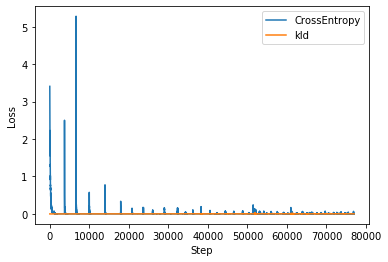

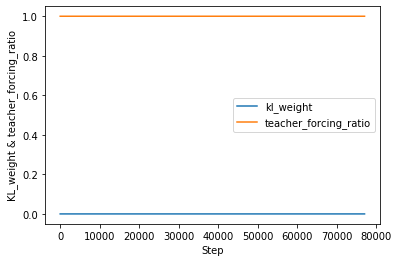

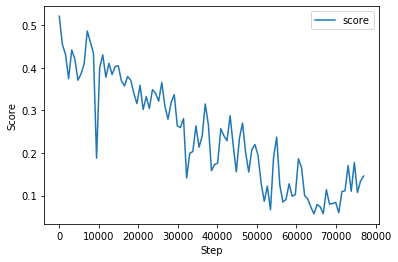

In [12]:
plt.figure()

load = True
if load:
    acc = np.load(loss_file)
    entropy = acc['entropy']
    kld = acc['kld']
    kl_weight = acc['kl_weight']
    teacher_forcing_ratio = acc['teacher_forcing_ratio']
    score = acc['score']
    
# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(entropy)+1)
plt.plot(x, entropy, label="CrossEntropy")
plt.plot(x, kld, label="kld")
plt.legend()
plt.show()
plt.clf()

plt.ylabel("KL_weight & teacher_forcing_ratio")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(kl_weight)+1)
plt.plot(x, kl_weight, label="kl_weight")
plt.plot(x, teacher_forcing_ratio, label="teacher_forcing_ratio")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

plt.ylabel("Score")
plt.xlabel("Step")
# print(test_loss)
x = np.linspace(1, len(kl_weight)+1, len(score))
plt.plot(x, score, label="score")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()


In [13]:
def reparaterization_trick(mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std
    
def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = './train.txt'#should be your directory of train.txt
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)

    
label = torch.LongTensor([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]]).to(device)

decoder.eval()
words = []
for i in range(100):        

    hidden_mean = torch.randn([1, 1, 32]).to(device)
    hidden_logv = torch.randn([1, 1, 32]).to(device)
    cell_mean = torch.randn([1, 1, 32]).to(device)
    cell_logv = torch.randn([1, 1, 32]).to(device)

    encoder_hidden = reparaterization_trick(hidden_mean, hidden_logv)
    encoder_cell = reparaterization_trick(cell_mean, cell_logv)
    
    tmp = []
    for i in range(4):
        hidden = torch.cat([encoder_hidden, label[i].view(1, 1, 4)], dim=2)
        hidden = decoder.latent2hidden(hidden)
        cell = torch.cat([encoder_cell, label[i].view(1, 1, 4)], dim=2)
        cell = decoder.latent2hidden(cell)

        decoded_indices = decoder.evaluate(context_vector=hidden, decoder_cell=cell)

        results = []
        for indices in decoded_indices:
            results.append(train_loader.vocab.indices_to_sequence(indices))
        tmp.append(results[0])
    words.append(tmp)
print(words)
print(Gaussian_score(words))

[['derize', 'dercap', 'dercap', 'dercap'], ['endir', 'renact', 'weasi', 'endiat'], ['stering', 'stering', 'stering', 'stering'], ['westing', 'westing', 'winse', 'westing'], ['sh', 'shear', 'sh', 'shdear'], ['nage', 'nounding', 'nagun', 'nagun'], ['thering', 'pering', 'bering', 'tering'], ['atend', 'apled', 'anted', 'anted'], ['orment', 'usters', 'uspemban', 'uspearted'], ['tering', 'tering', 'tering', 'tering'], ['belting', 'belling', 'belling', 'belting'], ['rending', 'resen', 'resing', 'restance'], ['muried', 'urcembing', 'muried', 'murien'], ['conser', 'conser', 'consure', 'conser'], ['pealing', 'peling', 'peling', 'peuling'], ['esting', 'esting', 'stance', 'esting'], ['endir', 'endinquo', 'buncis', 'ensting'], ['anter', 'anter', 'anter', 'anter'], ['demany', 'dearing', 'dealing', 'dealing'], ['depjon', 'despon', 'sconge', 'stoerzen'], ['dering', 'derap', 'drepan', 'deraping'], ['ghint', 'ghen', 'ghinfing', 'ghen'], ['dorceam', 'dorceaze', 'docue', 'sorned'], ['corusent', 'counserin

In [14]:
total_score = 0.0
for i in range(len(test_src)):
    word = train_loader.vocab.indices_to_sequence(test_src[i])
    trg_true = train_loader.vocab.indices_to_sequence(test_trg[i])
    results = trainer.evaluate(word, test_c_src[i].view(1, -1), test_c_trg[i].view(1, -1))[0]
    score = trainer.compute_bleu(results, trg_true)
    print("Src_true: {:>12}".format(word), "\tTrg_true:{:>12}".format(trg_true), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
    total_score += score
total_score /= len(test_src)
print(total_score)

Src_true:      abandon 	Trg_true:   abandoned 	Predict: fouschanding 	Score:  0.09578
Src_true:         abet 	Trg_true:    abetting 	Predict: bestirbanying 	Score:  0.11302
Src_true:        begin 	Trg_true:      begins 	Predict:   deshifying 	Score:  0.05612
Src_true:       expend 	Trg_true:     expends 	Predict:  nexpledging 	Score:  0.11095
Src_true:         sent 	Trg_true:       sends 	Predict:    senstring 	Score:  0.12753
Src_true:        split 	Trg_true:   splitting 	Predict:  snisterking 	Score:  0.11095
Src_true:       flared 	Trg_true:       flare 	Predict: disanplering 	Score:  0.02409
Src_true:  functioning 	Trg_true:    function 	Predict: functringing 	Score:  0.34484
Src_true:  functioning 	Trg_true:  functioned 	Predict:  chlistoning 	Score:  0.05246
Src_true:      healing 	Trg_true:       heals 	Predict: sheldipaning 	Score:  0.04529
0.10810458220824519


In [15]:
torch.save(decoder, "lstm_decoder.pt")